# MLP

Compare MLP to LSTM on same data.
Compare to LSTM notebook 113.
K=3.  
Normalized K-mer counts.  
Two-layer MLP.  

## Environment setup

In [34]:
from datetime import datetime
print(datetime.now())
from platform import python_version
print('Python',python_version())
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt 
import sklearn   # pip install --upgrade scikit-learn
print('sklearn',sklearn.__version__)

2022-11-21 15:30:45.138602
Python 3.7.15
sklearn 1.0.2


In [35]:
import tensorflow as tf
dt='float32'
tf.keras.backend.set_floatx('float32')
tf.random.set_seed(42) 

from tensorflow import keras
from sklearn.model_selection import KFold
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.losses import BinaryCrossentropy

K=3
EPOCHS=100
FOLDS=5  
BREAK = False   # break after first fold
MAXLEN=4000   # this is problematic as some genes will be excluded entirely or partially
MINLEN=1000

In [36]:
try:
    from google.colab import drive
    IN_COLAB = True
    PATH='/content/drive/'
    drive.mount(PATH)
    DATA_DIR=PATH+'My Drive/data/Localization/TrainTest/'  # must end in "/"
except:
    IN_COLAB = False
    DATA_DIR = '/Users/jasonmiller/WVU/Localization/TrainTest/'    # Mac
    DATA_DIR = 'D:/Adjeroh/Localization/TrainTest/'   # Windows
print(DATA_DIR)

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).
/content/drive/My Drive/data/Localization/TrainTest/


In [37]:
GENES_FILE =    'CNRCI_coding_train_genes.csv'
RCI_FILE =      'CNRCI_coding_train_RCI.gc42.csv'
SEQUENCE_FILE = 'CNRCI_coding_train_transcripts.gc42.csv'
COUNTS_FILE=    'CNRCI_coding_train_counts.K3.gc42.csv'   # K=3

In [38]:
def get_ordered_list():
    ordered_list = \
    ['A549',\
      'H1.hESC',\
      'HeLa.S3',\
      'HepG2',\
      'HT1080',\
      'HUVEC',\
      'MCF.7',\
      'NCI.H460',\
      'NHEK',\
      'SK.MEL.5',\
      'SK.N.DZ',\
      'SK.N.SH',\
      'GM12878',\
      'K562',\
      'IMR.90']
    return ordered_list
CELL_LINE_NUMBER=1
all_cell_lines = get_ordered_list()
cell_line_name = all_cell_lines[CELL_LINE_NUMBER]
print('Cell line for today:',CELL_LINE_NUMBER,'=',cell_line_name)

Cell line for today: 1 = H1.hESC


## Data Load

In [39]:
print(datetime.now())
# labels
filepath = DATA_DIR+RCI_FILE
gene_to_rci = {}
with open (filepath,'r') as handle:
    header = None
    for row in handle:
        if header is None:
            header = row
        else:
            line = row.strip()
            fields = line.split(',')
            gene_id = fields[0]
            rci_val = fields[CELL_LINE_NUMBER+1]
            # Could implement Gudenas style threshold here
            if rci_val != "nan":
                gene_to_rci[gene_id] = float(rci_val)
print('Num RCI:', len(gene_to_rci.keys()))
print(list(gene_to_rci.items())[:3])
all_genes = list(gene_to_rci.keys())

2022-11-21 15:30:46.495308
Num RCI: 13000
[('ENSG00000000003', 1.85734), ('ENSG00000000005', 5.88264), ('ENSG00000000419', 2.58954)]


In [40]:
# kmer counts
print(datetime.now())
filepath = DATA_DIR+COUNTS_FILE
labels=[]
allids=[]
counts=[]
with open (filepath,'r') as handle:
    header = None
    for row in handle:
        if header is None:
            header = row
        else:
            line    = row.strip()
            fields  = line.split(',')
            gene_id = fields.pop(0)
            tran_id = fields.pop(0)
            numbers = [int(x) for x in fields]
            seq_len = sum(numbers)+K-1
            if seq_len>=MINLEN and seq_len<=MAXLEN and gene_id in gene_to_rci.keys():
                rci_val = gene_to_rci[gene_id]
                allids.append( (gene_id,tran_id) )
                labels.append(rci_val)
                counts.append(numbers)
print(datetime.now())
print('Normalize')
rows = len(counts)
cols = len(counts[0])
for row in range(rows):
    total = sum(counts[row])
    for col in range(cols):
        counts[row][col] /= total
print(datetime.now())
print('Num IDs:',len(allids))
#print('Examples:',[allids[x] for x in [10, 20, 30, 40]] )
print('Num labels:',len(labels))
#print('Examples:',[labels[x] for x in [10, 20, 30, 40]] )
print('Num counts:',len(counts))
#print('Example:',counts[3])

2022-11-21 15:30:46.760580
2022-11-21 15:30:48.082920
Normalize
2022-11-21 15:30:48.472611
Num IDs: 31220
Num labels: 31220
Num counts: 31220


In [41]:
def get_gene_subset(all_genes,sub_index):
    sub_genes = set()
    for index in sub_index:
        one_gene = all_genes[index]
        sub_genes.add(one_gene)
    return sub_genes
def get_X_y(gene_set,allids,allX,allY,threshold):
    cnt = len(allids)
    subsetX=[]
    subsetY=[]
    if cnt != len(allX) or cnt!= len(allY):
        raise Exception('Lengths differ')
    for i in range(cnt):
        gene_id,tran_id = allids[i]
        if gene_id in gene_set:
            oneX = allX[i]
            oneY = allY[i]
            if oneY < threshold:
                Yvalue = int(0)
            else:
                Yvalue = int(1)
            subsetX.append(oneX)
            subsetY.append(Yvalue)
    return subsetX,subsetY

## Model design

In [42]:
def build_model():
    ALPHABET=4**K  # NUMBER OF DISTINCT KMERS POSSIBLE
    mlp    = Sequential()
    layer1 = Dense(64, activation='sigmoid',dtype=dt,input_dim=ALPHABET)
    layer2 = Dense(8, activation='sigmoid')
    output = Dense(1, activation='sigmoid')
    mlp.add(layer1)
    mlp.add(layer2)
    mlp.add(output)
      
    bc=BinaryCrossentropy(from_logits=False)
    print("COMPILE...")
    mlp.compile(loss=bc, optimizer="Adam",metrics=["accuracy"])
    print("...COMPILED")
    return mlp

In [43]:
print(datetime.now())
model=build_model()
print(model.summary())  # Print this only once

2022-11-21 15:30:48.522745
COMPILE...
...COMPILED
Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_27 (Dense)            (None, 64)                4160      
                                                                 
 dense_28 (Dense)            (None, 8)                 520       
                                                                 
 dense_29 (Dense)            (None, 1)                 9         
                                                                 
Total params: 4,689
Trainable params: 4,689
Non-trainable params: 0
_________________________________________________________________
None


## Train and validate with all K-mer counts

In [44]:
SCALING = False
def do_cross_validation(eps):
    cv_scores = []
    fold=0
    print(datetime.now())
    print('splitting')
    # KFold shuffles once before making the partitions
    splitter = KFold(n_splits=FOLDS,shuffle=True,random_state=42)
    for train_index,valid_index in splitter.split(all_genes):
        fold += 1
        print('Fold',fold)
        train_genes = get_gene_subset(all_genes,train_index)
        valid_genes = get_gene_subset(all_genes,valid_index)
        X_train,y_train = get_X_y(train_genes,allids,counts,labels,0)
        X_valid,y_valid = get_X_y(valid_genes,allids,counts,labels,0)

        if SCALING:
            print('scaling')
            print(datetime.now())
            scaler = StandardScaler()
            scaler.fit(X_train)
            X_train = scaler.transform(X_train)
            X_valid = scaler.transform(X_valid)

        print('Train sizes',len(X_train),len(y_train))
        print('Valid sizes',len(X_valid),len(y_valid))
        print('Train set ones/size',
              np.count_nonzero(y_train),'/',len(y_train))
        print('Valid set ones/size',
              np.count_nonzero(y_valid),'/',len(y_valid))

        print("BUILD MODEL")
        model=build_model()

        print("FIT")
        print(datetime.now())
        history=model.fit(X_train, y_train, # batch_size=10, default=32 works nicely
                epochs=EPOCHS, verbose=1,  # verbose=1 for ascii art, verbose=0 for none
                validation_data=(X_valid,y_valid) )

        pd.DataFrame(history.history).plot(figsize=(8,5))
        plt.grid(True)
        plt.gca().set_ylim(0,1)
        plt.show()

        print("Compute valiation accuracy")
        print(datetime.now())
        scores = model.evaluate(X_valid, y_valid, verbose=0)
        print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))
        print(datetime.now())
        cv_scores.append(scores[1] * 100)
    return cv_scores

2022-11-21 15:30:48.660805
2022-11-21 15:30:48.662237
splitting
Fold 1
Train sizes 24903 24903
Valid sizes 6317 6317
Train set ones/size 12187 / 24903
Valid set ones/size 3025 / 6317
BUILD MODEL
COMPILE...
...COMPILED
FIT
2022-11-21 15:30:48.759488
Epoch 1/100
779/779 [==============================] - 4s 5ms/step - loss: 0.6810 - accuracy: 0.5889 - val_loss: 0.6581 - val_accuracy: 0.6864
Epoch 2/100
779/779 [==============================] - 2s 2ms/step - loss: 0.6189 - accuracy: 0.6935 - val_loss: 0.5985 - val_accuracy: 0.6910
Epoch 3/100
779/779 [==============================] - 2s 2ms/step - loss: 0.5917 - accuracy: 0.6983 - val_loss: 0.5906 - val_accuracy: 0.6945
Epoch 4/100
779/779 [==============================] - 2s 2ms/step - loss: 0.5884 - accuracy: 0.6997 - val_loss: 0.5879 - val_accuracy: 0.6965
Epoch 5/100
779/779 [==============================] - 2s 2ms/step - loss: 0.5865 - accuracy: 0.7016 - val_loss: 0.5859 - val_accuracy: 0.6959
Epoch 6/100
779/779 [===============

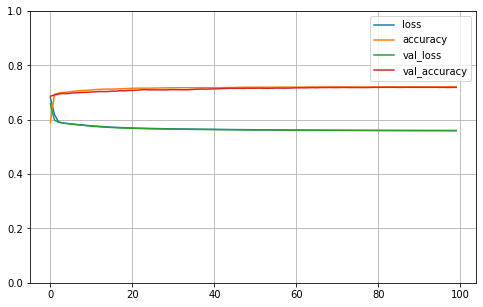

Compute valiation accuracy
2022-11-21 15:34:57.963821
accuracy: 71.89%
2022-11-21 15:35:00.289788
Fold 2
Train sizes 24921 24921
Valid sizes 6299 6299
Train set ones/size 12133 / 24921
Valid set ones/size 3079 / 6299
BUILD MODEL
COMPILE...
...COMPILED
FIT
2022-11-21 15:35:00.370551
Epoch 1/100
779/779 [==============================] - 4s 5ms/step - loss: 0.6847 - accuracy: 0.5904 - val_loss: 0.6686 - val_accuracy: 0.6199
Epoch 2/100
779/779 [==============================] - 2s 3ms/step - loss: 0.6302 - accuracy: 0.6863 - val_loss: 0.6055 - val_accuracy: 0.6852
Epoch 3/100
779/779 [==============================] - 2s 3ms/step - loss: 0.5919 - accuracy: 0.6958 - val_loss: 0.5954 - val_accuracy: 0.6946
Epoch 4/100
779/779 [==============================] - 2s 3ms/step - loss: 0.5871 - accuracy: 0.6981 - val_loss: 0.5934 - val_accuracy: 0.6947
Epoch 5/100
779/779 [==============================] - 2s 2ms/step - loss: 0.5850 - accuracy: 0.6999 - val_loss: 0.5919 - val_accuracy: 0.6963
Ep

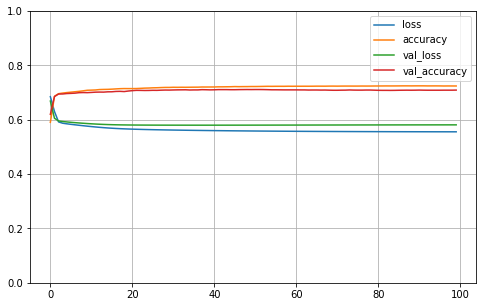

Compute valiation accuracy
2022-11-21 15:39:16.091467
accuracy: 70.90%
2022-11-21 15:39:18.326687
Fold 3
Train sizes 24914 24914
Valid sizes 6306 6306
Train set ones/size 12233 / 24914
Valid set ones/size 2979 / 6306
BUILD MODEL
COMPILE...
...COMPILED
FIT
2022-11-21 15:39:18.408661
Epoch 1/100
779/779 [==============================] - 5s 5ms/step - loss: 0.6786 - accuracy: 0.5904 - val_loss: 0.6484 - val_accuracy: 0.6966
Epoch 2/100
779/779 [==============================] - 2s 3ms/step - loss: 0.6142 - accuracy: 0.6925 - val_loss: 0.5950 - val_accuracy: 0.6998
Epoch 3/100
779/779 [==============================] - 2s 3ms/step - loss: 0.5898 - accuracy: 0.6958 - val_loss: 0.5907 - val_accuracy: 0.7023
Epoch 4/100
779/779 [==============================] - 2s 3ms/step - loss: 0.5865 - accuracy: 0.6971 - val_loss: 0.5889 - val_accuracy: 0.7058
Epoch 5/100
779/779 [==============================] - 2s 3ms/step - loss: 0.5843 - accuracy: 0.6998 - val_loss: 0.5873 - val_accuracy: 0.7088
Ep

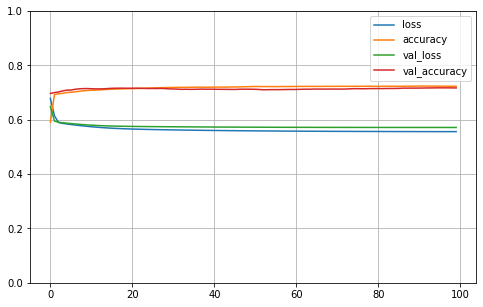

Compute valiation accuracy
2022-11-21 15:43:41.384426
accuracy: 71.69%
2022-11-21 15:43:44.064496
Fold 4
Train sizes 24986 24986
Valid sizes 6234 6234
Train set ones/size 12223 / 24986
Valid set ones/size 2989 / 6234
BUILD MODEL
COMPILE...
...COMPILED
FIT
2022-11-21 15:43:44.161982
Epoch 1/100
781/781 [==============================] - 5s 6ms/step - loss: 0.6834 - accuracy: 0.5907 - val_loss: 0.6613 - val_accuracy: 0.6471
Epoch 2/100
781/781 [==============================] - 2s 3ms/step - loss: 0.6236 - accuracy: 0.6894 - val_loss: 0.5946 - val_accuracy: 0.7004
Epoch 3/100
781/781 [==============================] - 2s 3ms/step - loss: 0.5919 - accuracy: 0.6948 - val_loss: 0.5888 - val_accuracy: 0.7008
Epoch 4/100
781/781 [==============================] - 2s 3ms/step - loss: 0.5887 - accuracy: 0.6965 - val_loss: 0.5868 - val_accuracy: 0.7007
Epoch 5/100
781/781 [==============================] - 2s 3ms/step - loss: 0.5869 - accuracy: 0.6980 - val_loss: 0.5851 - val_accuracy: 0.7010
Ep

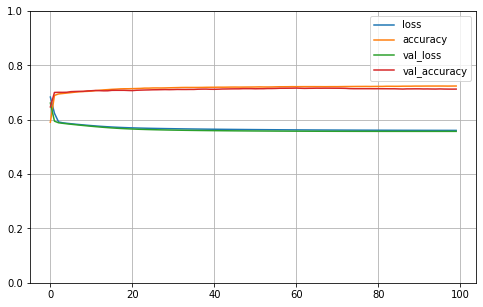

Compute valiation accuracy
2022-11-21 15:48:15.094668
accuracy: 71.27%
2022-11-21 15:48:17.342308
Fold 5
Train sizes 25156 25156
Valid sizes 6064 6064
Train set ones/size 12072 / 25156
Valid set ones/size 3140 / 6064
BUILD MODEL
COMPILE...
...COMPILED
FIT
2022-11-21 15:48:17.425908
Epoch 1/100
787/787 [==============================] - 5s 6ms/step - loss: 0.6834 - accuracy: 0.5470 - val_loss: 0.6700 - val_accuracy: 0.5821
Epoch 2/100
787/787 [==============================] - 2s 3ms/step - loss: 0.6319 - accuracy: 0.6831 - val_loss: 0.6045 - val_accuracy: 0.6933
Epoch 3/100
787/787 [==============================] - 2s 3ms/step - loss: 0.5961 - accuracy: 0.6958 - val_loss: 0.5904 - val_accuracy: 0.6981
Epoch 4/100
787/787 [==============================] - 3s 4ms/step - loss: 0.5905 - accuracy: 0.6979 - val_loss: 0.5866 - val_accuracy: 0.6981
Epoch 5/100
787/787 [==============================] - 3s 4ms/step - loss: 0.5881 - accuracy: 0.7002 - val_loss: 0.5844 - val_accuracy: 0.6994
Ep

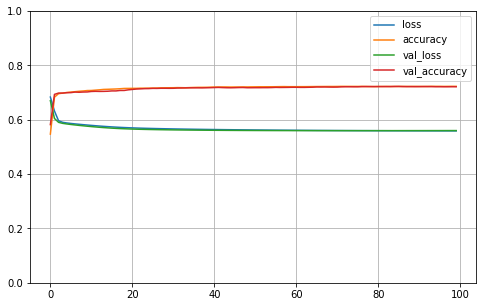

Compute valiation accuracy
2022-11-21 15:52:42.825798
accuracy: 72.13%
2022-11-21 15:52:45.063739
Cross validation acc mean 71.58% (+/- 0.44%)
2022-11-21 15:52:45.066542


In [45]:
print(datetime.now())
cv_scores = do_cross_validation(EPOCHS)    
print("Cross validation acc mean %.2f%% (+/- %.2f%%)" % (np.mean(cv_scores), np.std(cv_scores)))
print(datetime.now())